# 時系列データに対する３つの特徴把握方法
- 変動成分 
- 定常性
- コレログラム

## 変動成分

時系列データの原系列（元の時系列データ）は、主に以下の4つの変動成分で構成されます。<br>
T : 趨勢変動成分  
C : 循環変動成分  
S : 季節変動成分  
I : 不規則変動成分  

趨勢変動成分  
データの長期的な増加または減少を表現する成分。

循環変動成分  
周期的なパターンを表現する成分。後に説明する季節変動成分と似たような概念だが、季節変動成分が一定の周期を持っているのに対し、こちらの周期は一定である必要はない。景気循環などがよい例。季節変動成分と異なり、2年以上と長くなる。

季節変動成分  
一定の周期パターンを持った成分。例えば、データの粒度が1日単位であれば、週周期や年周期。循環変動成分と比べ、周期が短く長くても1年程度である。

よく、T（趨勢変動成分）とC（循環変動成分）を一緒くたに**TC（趨勢循環変動）**とまとめてしまうことが多い。<br>
その場合は<br>

- TC（趨勢循環変動）をトレンド成分
- S（季節変動成）を季節成分
- I（不規則変動成分）を残差成分<br>

と呼ぶ。

In [1]:
conda install -c conda-forge statsmodels

Solving environment: done

# All requested packages already installed.

Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [2]:
# ライブラリーの読み込み
import pandas as pd
import numpy as np
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

In [3]:
# データセットの読み込み
url='https://www.salesanalytics.co.jp/591h' #データセットのあるURL
df=pd.read_csv(url,                      #読み込むデータのURL
               index_col='Month',        #変数「Month」をインデックスに設定
               parse_dates=True)         #インデックスを日付型に設定
df.head() #確認

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


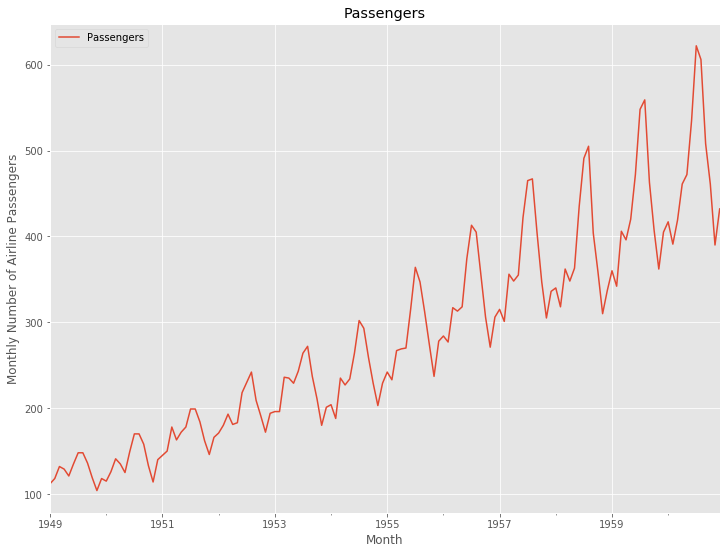

In [4]:
# プロット
df.plot()
plt.title('Passengers')                            #グラフタイトル
plt.ylabel('Monthly Number of Airline Passengers') #タテ軸のラベル
plt.xlabel('Month')                                #ヨコ軸のラベル
plt.show()

時系列データの入手後に行うこと
→３つの変動成分に分解

- トレンド成分
- 季節成分
- 残差成分

代表的な2つの成分分解法

- **移動平均法** を利用した分解（**加法モデル**　または　**乗法モデル** を仮定）
- **STL分解** （LOESS平滑化を利用した分解）

移動平均法を利用した分解方法
1. 設定した季節性の周期の移動平均を計算し、トレンド成分とする
2. 原系列からトレンド成分を除去し、季節成分（平均値を０に調整）を求める
3. 原系列からトレンド成分と季節成分を除去し、残差を求める

1. 移動平均を利用した分解（加法モデルを仮定）

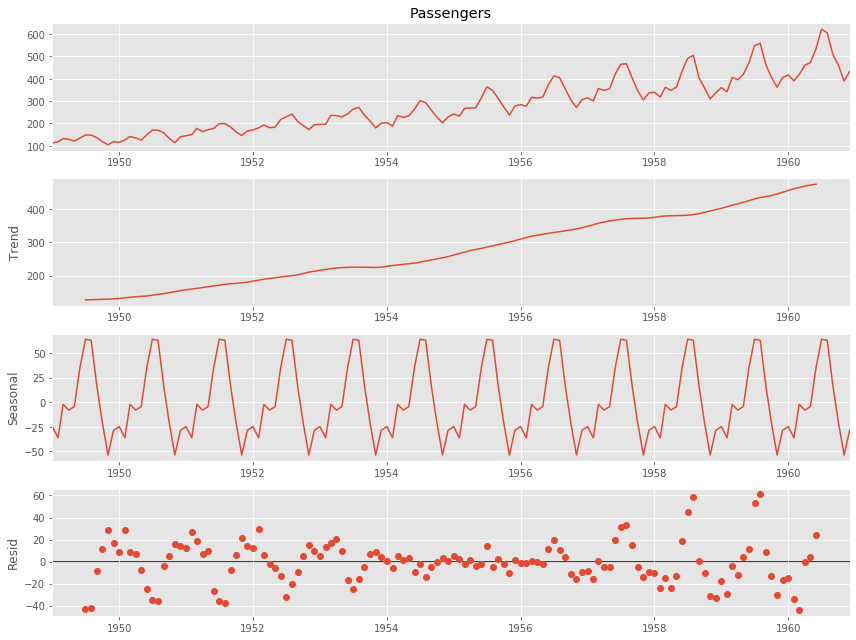

In [6]:
# 成分分解
result = seasonal_decompose(df.Passengers, model='additive', period=12)

# グラフ化
result.plot()
plt.show()

2. 移動平均を利用した分解（乗法モデルを仮定）

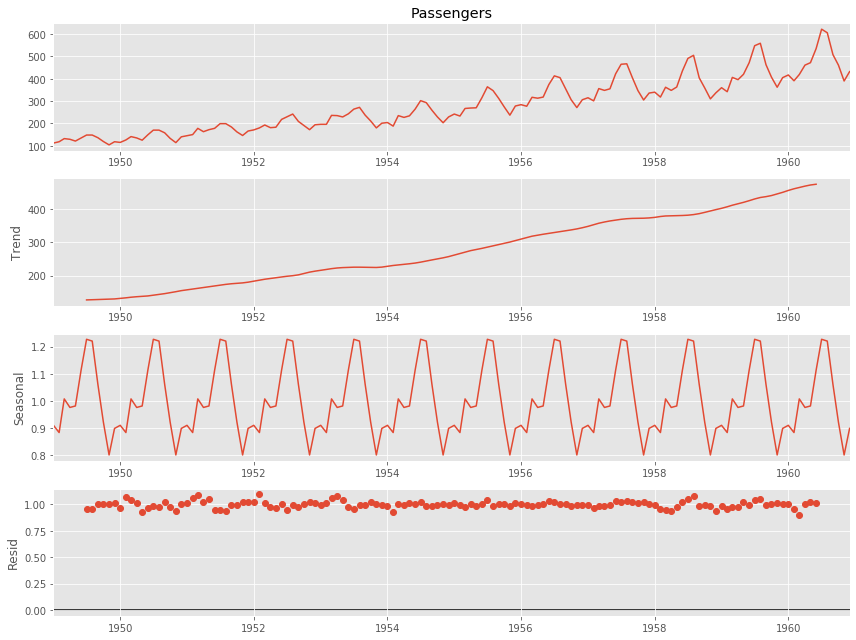

In [7]:
# 成分分解
result = seasonal_decompose(df.Passengers, model='multiplicative', period=12)

# グラフ化
result.plot()
plt.show()

3. STL分解（LOESS平滑化を利用した分解）

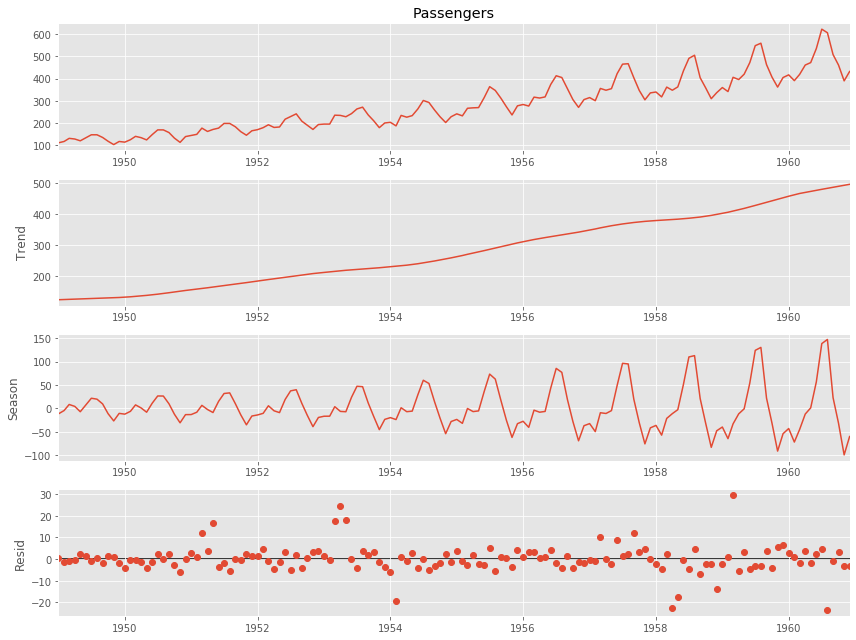

In [8]:
# 成分分解
stl = STL(df.Passengers, period=12, robust=True).fit()

# STL分解結果のグラフ化
stl.plot()
plt.show()

分解した結果から見ると、上昇傾向のトレンドと、12ヶ月周期（季節性）はありそう。

## 定常化

次に時系列データが定常かどうかを確認する。
そうすることで、**トレンド成分を考慮したモデルを作るべきなのか、季節成分を考慮したモデルを作るべきかの判断がつく。**<br>

定常な時系列データとは、**時間によって平均や分散などが変化しない時系列データ**のことである。

方法はADF検定を行う。<br>

- 帰無仮説H0 : 時系列は非定常である（単位根を持つ）
- 対立仮説H1 : 時系列は定常である（単位根を持たない）

単位根過程（単位根を持つ時系列データ）は原系列は非定常だが、差分を取ると定常になるデータのことである。

1. 原系列に対するADF検定
2. 原系列を対数変換し得た対数系列に対するADF検定
3. 対数系列の階差系列（次数１）に対するADF検定
4. 対数系列の階差系列（次数１）の季節階差系列（次数１）に対するADF検定

2の対数変換は分散が大きくなることを抑えることができる。<br>
3の処理は線形トレンドを除去できる。<br>

1. 原系列に対するADF検定

In [12]:
dftest = adfuller(df.Passengers)

dftest

(0.815368879206063,
 0.9918802434376413,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

In [18]:
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical value :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: 0.815369
p-value: 0.991880
Critical value :
	 1% -3.4816817173418295
	 5% -2.8840418343195267
	 10% -2.578770059171598


見方<br>
有意の場合は、帰無仮説を棄却し、対立仮説を採択する。<br>
p値（p-value）:<br>
<0.01 : 1％有意<br>
<0.05 : 5%有意<br>
<0.1 : 10%有意<br>

今回はp-value: 0.991880という結果から、帰無仮説を棄却できないため、原系列は定常過程でない。

2. 原系列を対数変換し得た対数系列に対するADF検定 

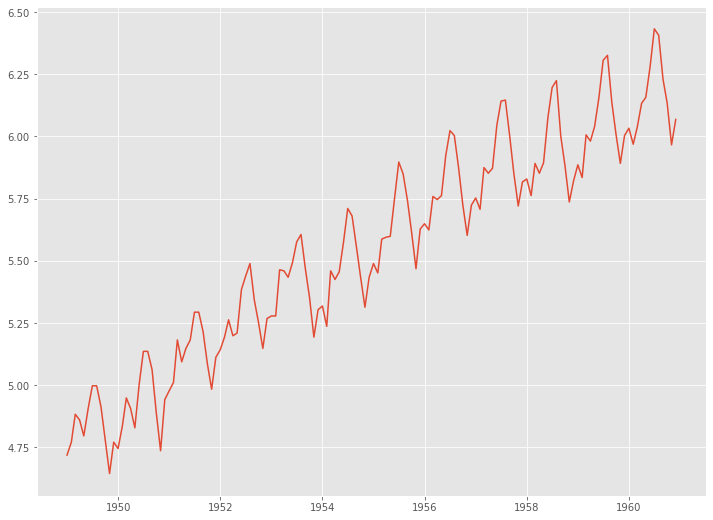

In [19]:
# 対数変換

df_log = np.log(df.Passengers)

plt.plot(df_log)

In [20]:
dftest = adfuller(df_log)

print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical value :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -1.717017
p-value: 0.422367
Critical value :
	 1% -3.4816817173418295
	 5% -2.8840418343195267
	 10% -2.578770059171598


今回はp-value: 0.422367という結果から、帰無仮説を棄却できないため、原系列を対数変換し得た対数系列は定常過程でない。

3. 対数系列の階差系列（次数１）に対するADF検定

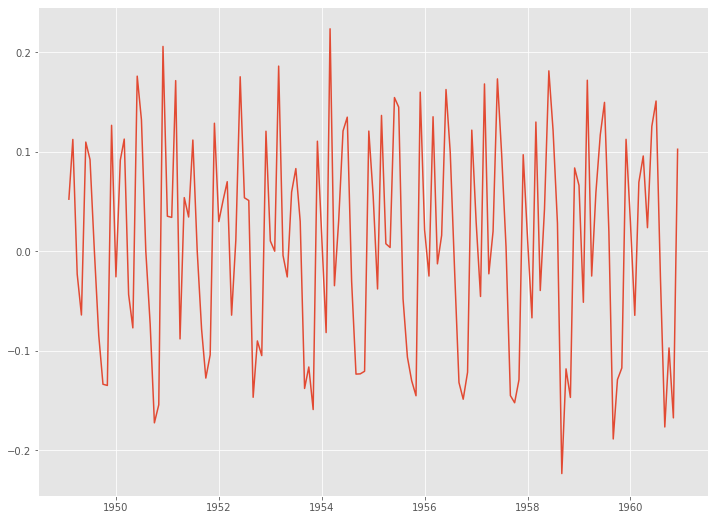

In [25]:
# 階差系列を作成し、線形トレンドを除去

df_log_diff1 = df_log.diff(1).dropna()

plt.plot(df_log_diff1)

In [26]:
dftest = adfuller(df_log_diff1)

print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical value :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -2.717131
p-value: 0.071121
Critical value :
	 1% -3.4825006939887997
	 5% -2.884397984161377
	 10% -2.578960197753906


１０％有意ではあるが、通常は５％有意からが対象となるので、今回も帰無仮説を棄却できないため、階差系列は定常過程でない。

4. 対数系列の階差系列（次数１）の季節階差系列（次数１）に対するADF検定

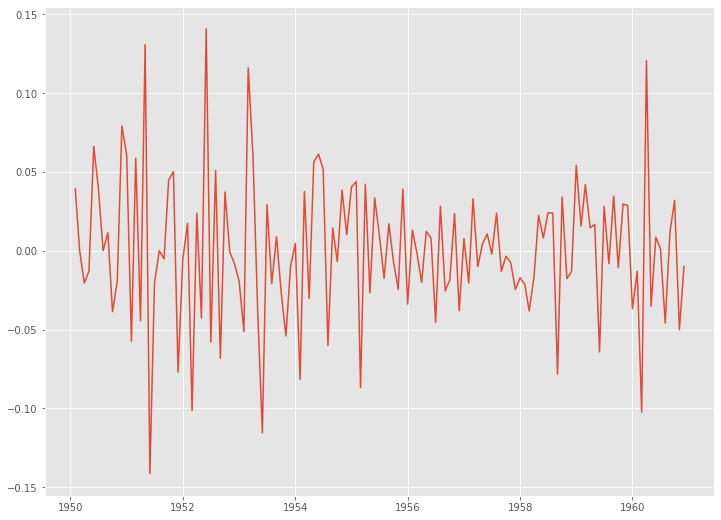

In [27]:
# 季節階差

df_log_diff1_diff12 = df_log_diff1.diff(12).dropna()

plt.plot(df_log_diff1_diff12)

In [28]:
dftest = adfuller(df_log_diff1_diff12)

print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical value :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -4.443325
p-value: 0.000249
Critical value :
	 1% -3.4870216863700767
	 5% -2.8863625166643136
	 10% -2.580009026141913


p-value:0.000249となり、帰無仮説は棄却され対立仮説が採択されたので、季節階差は定常である。

今回の時系列データは季節成分を考慮したモデルを作成するのがよさそうである。

## 定常化によく用いる３つに方法

- トレンド除去
- 差分化
- Box-Cox変換

## コレログラム

自己相関（ACF）と偏自己相関（PACF）をプロットしたグラフ。<br>
自己相関：原系列とそのラグとの相関<br>
偏自己相関：原系列とそのラグとの偏相関<br>
ラグ：時間をずらしたデータ

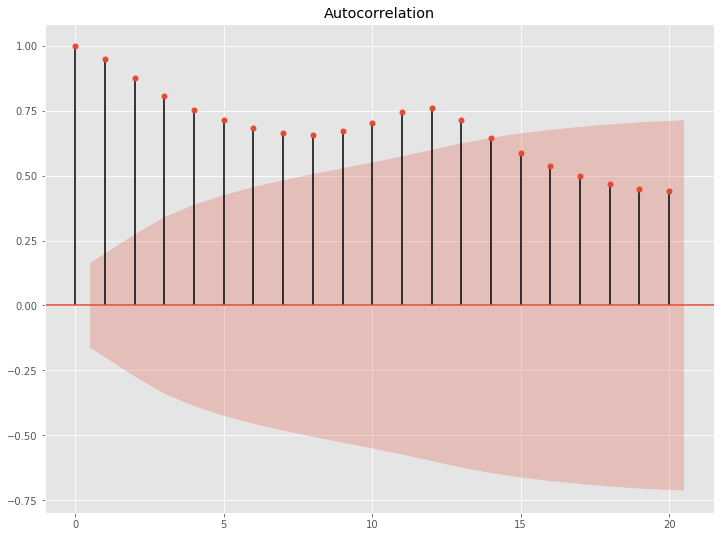

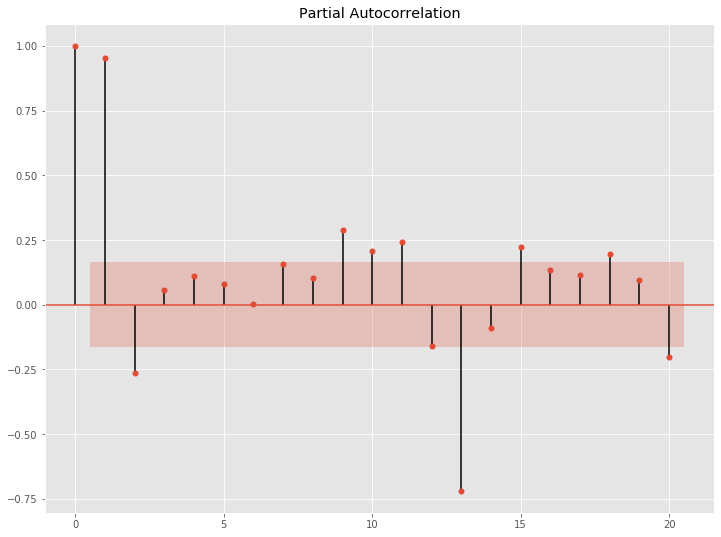

In [30]:
# 原系列のコレログラム
acf = plot_acf(df.Passengers, lags=20)
pacf = plot_pacf(df.Passengers, lags=20)

ACFのグラフから、原系列のトレンド成分の影響が伺える

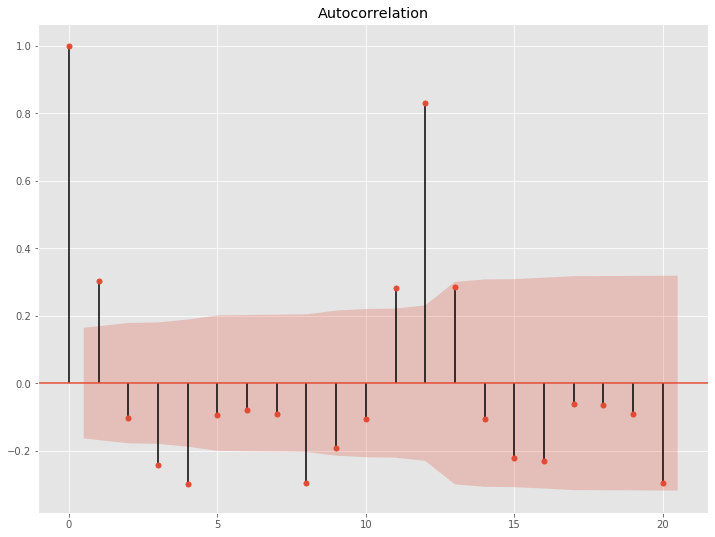

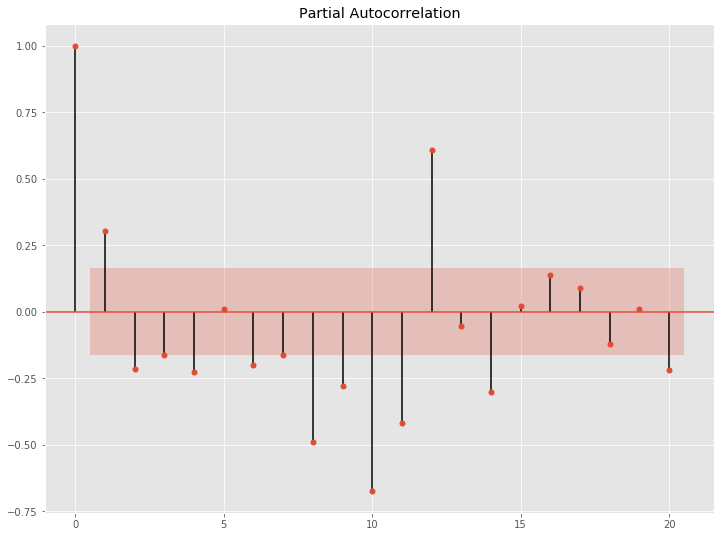

In [31]:
# 原系列の対数系列の階差系列（次数１）

acf = plot_acf(np.diff(df.Passengers, 1), lags=20)
pacf = plot_pacf(np.diff(df.Passengers, 1), lags=20)

ラグ１２などで数値が上がっている。<br>
解釈例としてはラグ１２が１２ヶ月前を意味しているので、１２ヶ月周期の季節性があることがわかる。

# 指数平滑化法で予測を行う

In [42]:
import platform

print(platform.python_version())

3.7.6
